## Hand Recognition using convnet. with Tensorflow

### Import and load

In [91]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, convert_to_one_hot, predict
from cnn_utils import *

%matplotlib inline
np.random.seed(1)

In [2]:
# Loading the dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y : 5


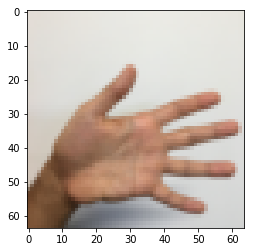

In [3]:
for index in range(1):
    plt.imshow(X_train_orig[index])
    print('y : '+str(np.squeeze(Y_train_orig[0,index])))
    plt.show()

In [4]:
X_train_orig.shape,Y_train_orig.shape
#Y_train_orig = Y_train_orig.T

((1080, 64, 64, 3), (1, 1080))

In [5]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


### Create placeholders

In [64]:
def create_placeholders(n_h0,n_w0,n_c0,n_y):
    X = tf.placeholder(tf.float32,[None,n_h0,n_w0,n_c0])
    Y = tf.placeholder(tf.float32,[None,n_y])
    return X,Y

In [14]:
X,Y = create_placeholder(64,64,3,6)
print(X)
print(Y)

Tensor("Placeholder_6:0", shape=(?, 64, 64, 3), dtype=float32)
Tensor("Placeholder_7:0", shape=(?, 6), dtype=float32)


### Initialize_parameters (using tf.get_variable)

In [68]:
def initialize_parameters():
    tf.set_random_seed(1)
    W1 = tf.get_variable('W1',[4,4,3,8],initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable('W2',[2,2,8,16],initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    parameters = {'W1':W1,
                  'W2':W2 }
    return parameters

In [69]:
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"]))
    print("W2 = " + str(parameters["W2"]))

W1 = <tf.Variable 'W1:0' shape=(4, 4, 3, 8) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(2, 2, 8, 16) dtype=float32_ref>


### Forward Propagation

#### Explanation

In TensorFlow, there are built-in functions that carry out the convolution steps for you.

- **tf.nn.conv2d(X,W1, strides = [1,s,s,1], padding = 'SAME'):** given an input $X$ and a group of filters $W1$, this function convolves $W1$'s filters on X. The third input ([1,f,f,1]) represents the strides for each dimension of the input (m, n_H_prev, n_W_prev, n_C_prev). You can read the full documentation [here](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d)

- **tf.nn.max_pool(A, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME'):** given an input A, this function uses a window of size (f, f) and strides of size (s, s) to carry out max pooling over each window. You can read the full documentation [here](https://www.tensorflow.org/api_docs/python/tf/nn/max_pool)

- **tf.nn.relu(Z1):** computes the elementwise ReLU of Z1 (which can be any shape). You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/nn/relu)

- **tf.contrib.layers.flatten(P)**: given an input P, this function flattens each example into a 1D vector it while maintaining the batch-size. It returns a flattened tensor with shape [batch_size, k]. You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/flatten)

- **tf.contrib.layers.fully_connected(F, num_outputs):** given a the flattened input F, it returns the output computed using a fully connected layer. You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/fully_connected)

In the last function above (`tf.contrib.layers.fully_connected`), the fully connected layer automatically initializes weights in the graph and keeps on training them as you train the model. Hence, you did not need to initialize those weights when initializing the parameters. 


#### Code

In [70]:
def forward_propagation(X,parameters):
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    Z1 = tf.nn.conv2d(X,W1,strides = [1,1,1,1],padding = 'SAME') # (m, n_H_prev, n_W_prev, n_C_prev) 
                                                                 #:[1,s,s,1]
    A1 = tf.nn.relu(Z1)
    # ksize = [1,f,f,1] f=8
    P1 = tf.nn.max_pool(A1,ksize = [1,8,8,1],strides = [1,8,8,1],padding = 'SAME')
    Z2 = tf.nn.conv2d(P1,W2,strides = [1,1,1,1],padding = 'SAME')
    A2 = tf.nn.relu(Z2)
    #f =4
    P2 = tf.nn.max_pool(A2,ksize = [1,4,4,1],strides = [1,4,4,1],padding = 'SAME')
    P = tf.contrib.layers.flatten(P2)
    Z3 = tf.contrib.layers.fully_connected(P,6,activation_fn=None)
    
    return Z3

In [72]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,64,64,3), Y: np.random.randn(2,6)})
    print("Z3 = " + str(a))

Z3 = [[ 1.4416982  -0.24909675  5.4504995  -0.26189643 -0.2066989   1.3654672 ]
 [ 1.4070848  -0.02573231  5.0892797  -0.48669893 -0.40940714  1.2624854 ]]


### Compute cost

In [79]:
def compute_cost(Z3,Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels =Y))
    return cost

In [80]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,64,64,3), Y: np.random.randn(4,6)})
    print("cost = " + str(a))

cost = 4.6648703


### Model

In [124]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.009,
          num_epochs=1000, minibatch_size=64, print_cost=True):
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = [] 
    
    X,Y = create_placeholders(n_H0, n_W0, n_C0,n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X,parameters)
    cost = compute_cost(Z3,Y)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    init  = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            minibatch_cost = 0
            num_minibatches = int(m/minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train,Y_train,minibatch_size,seed)
            
            for minibatch in minibatches:
                (minibatch_x,minibatch_y) = minibatch
                _,temp_cost = sess.run([optimizer,cost],feed_dict= {X:minibatch_x,Y:minibatch_y})
                minibatch_cost = temp_cost/num_minibatches
            
            if print_cost == True and epoch % 25 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        plt.plot(np.squeeze(costs))
        plt.xlabel('iterations')
        plt.ylabel('cost')
        plt.show()
        
        
        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

### Training

#### 1

Cost after epoch 0: 0.111860
Cost after epoch 25: 0.109645
Cost after epoch 50: 0.092129
Cost after epoch 75: 0.055525
Cost after epoch 100: 0.057205
Cost after epoch 125: 0.048836
Cost after epoch 150: 0.042248
Cost after epoch 175: 0.043787
Cost after epoch 200: 0.057759
Cost after epoch 225: 0.044549
Cost after epoch 250: 0.049167
Cost after epoch 275: 0.046076
Cost after epoch 300: 0.055025
Cost after epoch 325: 0.036352
Cost after epoch 350: 0.047989
Cost after epoch 375: 0.041745
Cost after epoch 400: 0.035294
Cost after epoch 425: 0.035590
Cost after epoch 450: 0.050960
Cost after epoch 475: 0.033875
Cost after epoch 500: 0.044156
Cost after epoch 525: 0.036305
Cost after epoch 550: 0.030663
Cost after epoch 575: 0.033455
Cost after epoch 600: 0.037350
Cost after epoch 625: 0.034050
Cost after epoch 650: 0.043020
Cost after epoch 675: 0.039934
Cost after epoch 700: 0.045901
Cost after epoch 725: 0.030574
Cost after epoch 750: 0.036588
Cost after epoch 775: 0.023170
Cost after ep

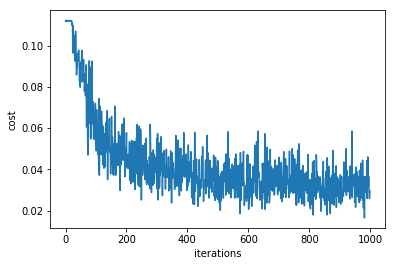

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.82685184
Test Accuracy: 0.6666667


In [121]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

epoch = 400
Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.8138889
Test Accuracy: 0.69166666

#### 2

Cost after epoch 0: 0.111644
Cost after epoch 25: 0.044131
Cost after epoch 50: 0.022442
Cost after epoch 75: 0.018015
Cost after epoch 100: 0.007112
Cost after epoch 125: 0.007973
Cost after epoch 150: 0.004883
Cost after epoch 175: 0.002044
Cost after epoch 200: 0.002146
Cost after epoch 225: 0.003390
Cost after epoch 250: 0.001797
Cost after epoch 275: 0.001376
Cost after epoch 300: 0.001461
Cost after epoch 325: 0.000676
Cost after epoch 350: 0.000475
Cost after epoch 375: 0.000577


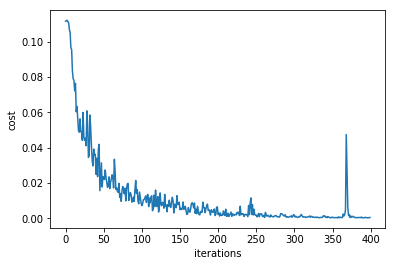

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 1.0
Test Accuracy: 0.8833333


In [126]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test,num_epochs=400,learning_rate=0.005)

#### 3

Cost after epoch 0: 0.112456
Cost after epoch 25: 0.061427
Cost after epoch 50: 0.038393
Cost after epoch 75: 0.035085
Cost after epoch 100: 0.018407
Cost after epoch 125: 0.013326
Cost after epoch 150: 0.011649
Cost after epoch 175: 0.012133
Cost after epoch 200: 0.009715
Cost after epoch 225: 0.011364
Cost after epoch 250: 0.005190
Cost after epoch 275: 0.007300
Cost after epoch 300: 0.005931
Cost after epoch 325: 0.005296
Cost after epoch 350: 0.001776


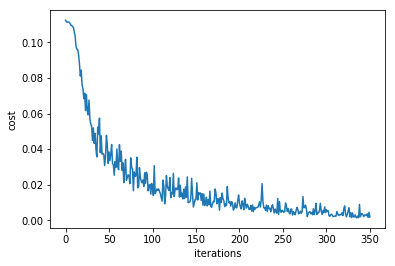

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.99722224
Test Accuracy: 0.8833333


In [127]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test,num_epochs=351,learning_rate=0.002)

#### 4

Cost after epoch 0: 0.223691
Cost after epoch 25: 0.125867
Cost after epoch 50: 0.087603
Cost after epoch 75: 0.070390
Cost after epoch 100: 0.040027
Cost after epoch 125: 0.043336
Cost after epoch 150: 0.017123
Cost after epoch 175: 0.016569
Cost after epoch 200: 0.009711
Cost after epoch 225: 0.014096
Cost after epoch 250: 0.006961
Cost after epoch 275: 0.011525
Cost after epoch 300: 0.006574
Cost after epoch 325: 0.004626
Cost after epoch 350: 0.002965


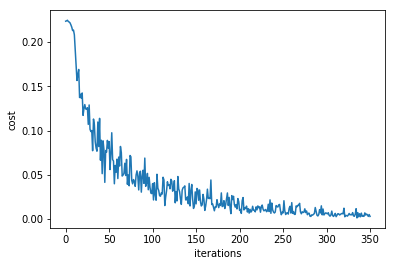

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.99722224
Test Accuracy: 0.90833336


In [131]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test,num_epochs=351,learning_rate=0.005,
                         minibatch_size=128)

#### 5

Cost after epoch 0: 0.450866
Cost after epoch 25: 0.294498
Cost after epoch 50: 0.199031
Cost after epoch 75: 0.116081
Cost after epoch 100: 0.094016
Cost after epoch 125: 0.062078
Cost after epoch 150: 0.041002
Cost after epoch 175: 0.026336
Cost after epoch 200: 0.059336
Cost after epoch 225: 0.034927
Cost after epoch 250: 0.033044
Cost after epoch 275: 0.026559
Cost after epoch 300: 0.018242
Cost after epoch 325: 0.013817
Cost after epoch 350: 0.007912


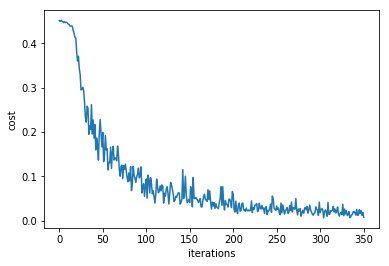

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.9851852
Test Accuracy: 0.89166665


In [132]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test,num_epochs=351,learning_rate=0.005,
                         minibatch_size=256)

###  hence model no. 4 is best with 90% accuracy